# Traveling Salesman Problem (TSP) Formulation

## Problem Summary
We consider a standard symmetric TSP instance with:
- **N** = 10 cities randomly distributed on a 2D plane (longitude ∈ [-180,180], latitude ∈ [-90,90])
- Each city is labeled with a unique alphabetical identifier (A, B, ..., Z, AA, AB, ...)
- The distance matrix **D** is Euclidean:
  
  $$
  D_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}
  $$
  
  where $(x_i, y_i)$ are the coordinates of city $i$.

## Mathematical Formulation
Find a permutation $\pi$ of cities {1,2,...,N} that minimizes the total tour length:

$$
\min_{\pi \in S_N} \left( \sum_{i=1}^{N-1} D_{\pi(i),\pi(i+1)} + D_{\pi(N),\pi(1)} \right)
$$

where:
- $S_N$ is the symmetric group of all possible permutations
- The tour must visit each city exactly once before returning to the starting city
- The distance matrix satisfies $D_{ij} = D_{ji}$ (symmetric) and $D_{ii} = 0$

data seed: 5200


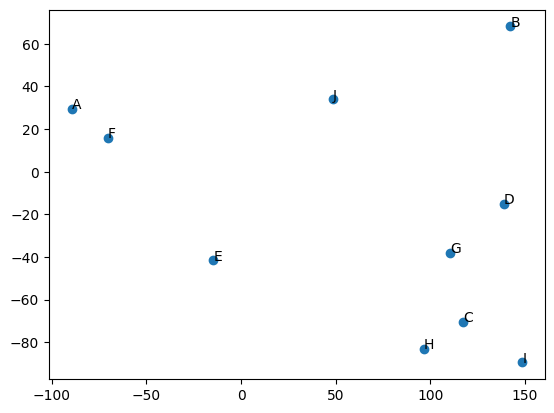

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import string

sd = np.random.randint(0, 10000)
print(f'data seed: {sd}')
np.random.seed(sd)

NUM_CITYS = 10

x = [np.random.uniform(-180, 180) for _ in range(NUM_CITYS)]
y = [np.random.uniform(-90, 90)   for _ in range(NUM_CITYS)]

# generate city name, number <= 26 * 27
def generate_city_labels(n):
    labels = []
    for i in range(n):
        if i < 26:
            labels.append(string.ascii_uppercase[i])
        else:
            labels.append(string.ascii_uppercase[i // 26 - 1] + string.ascii_uppercase[i % 26])
    return labels

dist = {i: label for i, label in enumerate(generate_city_labels(NUM_CITYS))}

# compute distance matrix
num_cities = len(x)
DIS = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        DIS[i,j] = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)

# show cities
plt.scatter(x, y)
for i, txt in enumerate(dist.values()):
    plt.annotate(txt, (x[i], y[i]))
plt.show()

### # Ant Colony Optimization for the Traveling Salesman Problem (ACO_TSP)

#### Introduction

Ant Colony Optimization (ACO) is a metaheuristic algorithm inspired by the foraging behavior of real ants. When applied to the Traveling Salesman Problem (TSP), ACO mimics how ants find the shortest path between food sources and their nest by depositing and following pheromone trails.

The key components of the ACO_TSP algorithm include:

1. **Pheromone trails**: Artificial pheromones are deposited on edges between cities, representing the desirability of that path
2. **Heuristic information**: Typically the inverse of distance, representing a priori preference for closer cities
3. **Probability rule**: Combines pheromone and heuristic information to determine the next city to visit
4. **Pheromone update**: Includes both evaporation (to forget bad solutions) and reinforcement (to remember good solutions)

#### Mathematical Formulation

##### 1. Transition Probability

The probability $p_{ij}^k$ that ant $k$ moves from city $i$ to city $j$ is given by:

$$
p_{ij}^k = \frac{[\tau_{ij}]^\alpha \cdot [\eta_{ij}]^\beta}{\sum_{l \in \mathcal{N}_i^k} [\tau_{il}]^\alpha \cdot [\eta_{il}]^\beta} \quad \text{if } j \in \mathcal{N}_i^k
$$

Where:
- $\tau_{ij}$ is the pheromone level on edge $(i,j)$
- $\eta_{ij} = \frac{1}{d_{ij}}$ is the heuristic information (inverse of distance)
- $\alpha$ controls the influence of pheromone (default=1)
- $\beta$ controls the influence of heuristic information (default=3)
- $\mathcal{N}_i^k$ is the set of unvisited cities for ant $k$ when at city $i$

##### 2. Pheromone Update

The pheromone update consists of two parts:

**Evaporation** (applied to all edges):

$$
\tau_{ij} \leftarrow (1 - \rho) \cdot \tau_{ij}
$$

Where $\rho$ is the evaporation rate (default=0.1).

**Deposition** (applied to edges in the solutions found by ants):

$$
\tau_{ij} \leftarrow \tau_{ij} + \sum_{k=1}^m \Delta \tau_{ij}^k
$$

Where $\Delta \tau_{ij}^k$ is the amount of pheromone deposited by ant $k$ on edge $(i,j)$:

$$
\Delta \tau_{ij}^k = \begin{cases}
\frac{Q}{L_k} & \text{if edge } (i,j) \text{ is in ant } k\text{'s tour} \\
0 & \text{otherwise}
\end{cases}
$$

Where:
- $Q$ is a constant (default=1)
- $L_k$ is the length of the tour constructed by ant $k$

##### 3. Tour Length Calculation

For a given path $p = [c_1, c_2, ..., c_n]$, the tour length is calculated as:

$$
L(p) = \sum_{i=1}^{n-1} d_{c_i,c_{i+1}} + d_{c_n,c_1}
$$

Where $d_{ij}$ is the distance between city $i$ and city $j$.

#### Algorithm Parameters

The ACO_TSP implementation uses the following parameters:
- `num_ants`: Number of ants in the colony (default=200)
- `max_iter`: Maximum number of iterations (default=50)
- `alpha`: Pheromone influence exponent (default=1)
- `beta`: Heuristic information exponent (default=3)
- `rho`: Evaporation rate (default=0.1)
- `Q`: Pheromone deposit constant (default=1)

The algorithm maintains:
- A pheromone matrix $\tau$ initialized to small values (default=0.1)
- The best path found and its length

In [3]:
class ACO_TSP:
    def __init__(self, distances, 
                 num_ants=200, 
                 max_iter=50, 
                 alpha=1, 
                 beta=3, 
                 rho=0.1, 
                 Q=1):

        self.distances = distances
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.n = len(distances)
        self.pheromone = np.ones((self.n, self.n)) * 0.1
        self.best_path = None
        self.best_length = float('inf')
        self.frames = []
    
    def run(self):
        for _ in range(self.max_iter):
            all_paths = []
            for _ in range(self.num_ants):
                path = self.build_path()
                all_paths.append(path)
            self.update_pheromone(all_paths)
            self.record_frame(all_paths)
    
    def build_path(self):
        path = [0]
        unvisited = set(range(1, self.n))
        while unvisited:
            current = path[-1]
            probs = []
            for city in unvisited:
                phe = self.pheromone[current][city] ** self.alpha
                vis = (1/(self.distances[current][city]+1e-10)) ** self.beta
                probs.append(phe * vis)
            probs = np.array(probs) / sum(probs)
            next_city = np.random.choice(list(unvisited), p=probs)
            path.append(next_city)
            unvisited.remove(next_city)
        return path
    
    def update_pheromone(self, all_paths):
        self.pheromone *= (1 - self.rho)
        for path in all_paths:
            length = self.calc_path_length(path)
            delta = self.Q / length
            for i in range(len(path)-1):
                self.pheromone[path[i], path[i+1]] += delta
            self.pheromone[path[-1], path[0]] += delta
            if length < self.best_length:
                self.best_length = length
                self.best_path = path + [path[0]]
    
    def calc_path_length(self, path):
        return sum(self.distances[path[i], path[i+1]] for i in range(len(path)-1)) \
               + self.distances[path[-1], path[0]]
    
    def record_frame(self, all_paths):
        current_path = all_paths[0] + [all_paths[0][0]]
        x_curr = [x[i] for i in current_path]
        y_curr = [y[i] for i in current_path]
        x_best = [x[i] for i in self.best_path]
        y_best = [y[i] for i in self.best_path]
        self.frames.append(('ACO', x_curr, y_curr, x_best, y_best, self.best_length))

### # Particle Swarm Optimization for the Traveling Salesman Problem (PSO_TSP)

#### Introduction

Particle Swarm Optimization (PSO) is a population-based metaheuristic inspired by the social behavior of bird flocking or fish schooling. When adapted for the Traveling Salesman Problem (TSP), PSO represents potential solutions as particles moving through the search space of possible tours.

Key features of this PSO_TSP implementation:

1. **Hybrid initialization**: Combines greedy solutions (80% by default) with random permutations
2. **Discrete velocity representation**: Uses swap operations between cities to modify tours
3. **Local search enhancement**: Incorporates 2-opt optimization for path refinement
4. **Social learning**: Particles are influenced by both personal best (pbest) and global best (gbest) solutions

#### Mathematical Formulation

##### 1. Velocity Update

The velocity update equation for discrete PSO is adapted as:

$$
v_i^{t+1} = w \cdot v_i^t + c_1 \cdot r_1 \cdot \text{diff}(x_i^t, \text{pbest}_i) + c_2 \cdot r_2 \cdot \text{diff}(x_i^t, \text{gbest})
$$

Where:
- $v_i^t$ is the velocity (number of swaps) of particle $i$ at iteration $t$
- $w$ is the inertia weight (default=0.8)
- $c_1$, $c_2$ are cognitive and social coefficients (default=1.5)
- $r_1$, $r_2$ are random numbers in [0,1]
- $\text{diff}(a,b)$ calculates the number of swap operations needed to transform path $a$ into path $b$

##### 2. Position Update

The position (path) update is performed by applying $v_i^{t+1}$ swap operations:

$$
x_i^{t+1} = \text{apply\_swaps}(x_i^t, v_i^{t+1})
$$

Where $\text{apply\_swaps}$ randomly selects $|v_i^{t+1}|$ pairs of cities to swap in the current path.

##### 3. Path Difference Metric

The difference between two paths is calculated as the minimum number of swaps needed to make them identical:

$$
\text{diff}(p,q) = \min\{\text{swap\_count} | \text{apply\_swaps}(p, \text{swap\_count}) = q\}
$$

##### 4. 2-opt Local Search

The 2-opt operation improves paths by reversing segments when beneficial:

For a path $p = [c_1, c_2, ..., c_n]$, consider all possible segment reversals $p[i..j]$ and accept if:

$$
d(c_i,c_j) + d(c_{i+1},c_{j+1}) < d(c_i,c_{i+1}) + d(c_j,c_{j+1})
$$

Where $d(a,b)$ is the distance between cities $a$ and $b$.

##### 5. Path Length Calculation

The tour length for path $p$ is computed as:

$$
L(p) = \sum_{i=1}^{n-1} d(p_i,p_{i+1}) + d(p_n,p_1)
$$

#### Algorithm Parameters

The PSO_TSP implementation uses these key parameters:
- `num_particles`: Swarm size (default=500)
- `max_iter`: Maximum iterations (default=200)
- `w`: Inertia weight (default=0.8)
- `c1`: Cognitive coefficient (default=1.5)
- `c2`: Social coefficient (default=1.5)
- `greedy_solutions`: Proportion of greedy initial solutions (default=0.8)

The algorithm maintains:
- Personal best (pbest) paths and lengths for each particle
- Global best (gbest) path and length
- Velocity representing the number of swap operations

#### Implementation Notes

1. **Initialization**:
   - Generates greedy solutions starting from random cities
   - Completes population with random permutations

2. **Velocity Clipping**:
   - Limits velocity to $[0, n/2]$ where $n$ is the number of cities

3. **Path Improvement**:
   - Applies 2-opt local search after each velocity update
   - Continuously updates personal and global best solutions

This discrete PSO adaptation effectively combines swarm intelligence principles with combinatorial optimization techniques to solve TSP, demonstrating how continuous optimization concepts can be adapted for discrete problems.

In [4]:
class PSO_TSP:
    def __init__(self, distances, 
                 num_particles=500, 
                 max_iter=200, w=0.8, 
                 c1=1.5, 
                 c2=1.5, 
                 greedy_solutions=0.8):
        
        self.distances = distances
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.n = len(distances)
        self.gbest_path = None
        self.gbest_length = float('inf')
        self.frames = []
        
        greedy_solutions = self._generate_greedy_solutions(int(num_particles*greedy_solutions))
        self.particles = []
        for i in range(num_particles):
            if i < len(greedy_solutions):
                path = greedy_solutions[i]
            else:
                path = np.random.permutation(self.n).tolist()
            velocity = 0
            pbest_path = path.copy()
            pbest_length = self._calc_path_length(path)
            if pbest_length < self.gbest_length:
                self.gbest_length = pbest_length
                self.gbest_path = path.copy()
            self.particles.append({
                'path': path,
                'velocity': velocity,
                'pbest_path': pbest_path,
                'pbest_length': pbest_length
            })
    
    def _generate_greedy_solutions(self, num_solutions):
        solutions = []
        for _ in range(num_solutions):
            start = np.random.randint(self.n)
            path = [start]
            unvisited = set(range(self.n)) - {start}
            while unvisited:
                last = path[-1]
                next_city = min(unvisited, key=lambda x: self.distances[last][x])
                path.append(next_city)
                unvisited.remove(next_city)
            solutions.append(path)
        return solutions
    
    def run(self):
        for _ in range(self.max_iter):
            for p in self.particles:
                v_pbest = self._path_difference(p['path'], p['pbest_path'])
                v_gbest = self._path_difference(p['path'], self.gbest_path)
                new_velocity = self.w * p['velocity'] + self.c1 * np.random.rand() * v_pbest + self.c2 * np.random.rand() * v_gbest
                new_velocity = np.clip(new_velocity, 0, self.n//2)
                
                new_path = self._apply_velocity(p['path'], new_velocity)
                
                new_path = self._two_opt(new_path)
                
                new_length = self._calc_path_length(new_path)
                
                if new_length < p['pbest_length']:
                    p['pbest_path'] = new_path.copy()
                    p['pbest_length'] = new_length
                    if new_length < self.gbest_length:
                        self.gbest_length = new_length
                        self.gbest_path = new_path.copy()
                p['path'] = new_path
                p['velocity'] = new_velocity
            
            self._record_frame()
    
    def _two_opt(self, path):
        best_path = path.copy()
        best_length = self._calc_path_length(path)
        n = self.n
        improved = True
        while improved:
            improved = False
            for i in range(n - 1):
                for j in range(i + 2, n):
                    if j == n and i == 0:
                        continue

                    delta = (self.distances[best_path[i]][best_path[j]] + 
                            self.distances[best_path[i+1]][best_path[(j+1)%n]] -
                            self.distances[best_path[i]][best_path[i+1]] - 
                            self.distances[best_path[j]][best_path[(j+1)%n]])
                    if delta < -1e-6:  # improved
                        best_path[i+1:j+1] = best_path[j:i:-1]
                        best_length += delta
                        improved = True
        return best_path
    
    def _path_difference(self, path1, path2):
        swap_count = 0
        temp = path1.copy()
        for i in range(self.n):
            if temp[i] != path2[i]:
                j = temp.index(path2[i])
                temp[i], temp[j] = temp[j], temp[i]
                swap_count += 1
        return swap_count
    
    def _apply_velocity(self, path, velocity):
        new_path = path.copy()
        swap_times = int(abs(velocity))
        for _ in range(swap_times):
            i, j = np.random.choice(self.n, 2, replace=False)
            new_path[i], new_path[j] = new_path[j], new_path[i]
        return new_path
    
    def _calc_path_length(self, path):
        return sum(self.distances[path[i]][path[i+1]] for i in range(self.n-1)) + self.distances[path[-1]][path[0]]
    
    def _record_frame(self):
        current_path = self.particles[0]['path'] + [self.particles[0]['path'][0]]
        x_curr = [x[i] for i in current_path] if 'x' in globals() else []
        y_curr = [y[i] for i in current_path] if 'y' in globals() else []
        x_best = [x[i] for i in self.gbest_path] + [x[self.gbest_path[0]]] if self.gbest_path else []
        y_best = [y[i] for i in self.gbest_path] + [y[self.gbest_path[0]]] if self.gbest_path else []
        self.frames.append(('PSO', x_curr, y_curr, x_best, y_best, self.gbest_length))

### # Genetic Algorithm for the Traveling Salesman Problem (GA_TSP)

#### Introduction

Genetic Algorithms (GA) are evolutionary computation techniques inspired by biological evolution. When applied to the Traveling Salesman Problem (TSP), GA evolves a population of candidate solutions through selection, crossover, and mutation operations.

Key features of this GA_TSP implementation:

1. **Hybrid initialization**: Combines greedy nearest-neighbor solutions (30% by default) with random permutations
2. **Adaptive parameters**: Dynamically adjusts mutation rates based on search progress
3. **Enhanced operators**: Uses Order Crossover (OX) and 2-opt local search
4. **Elitism preservation**: Maintains top solutions between generations

#### Mathematical Formulation

##### 1. Fitness Function

The fitness of a path $p$ is defined as the inverse of its tour length:

$$
f(p) = \frac{1}{L(p)} = \frac{1}{\sum_{i=1}^{n-1} d(p_i,p_{i+1}) + d(p_n,p_1)}
$$

Where $d(a,b)$ is the distance between cities $a$ and $b$.

##### 2. Selection (Tournament Selection)

For each selection operation:

1. Randomly select $k$ individuals (default $k=3$)
2. Choose the one with highest fitness:

$$
p_{\text{selected}} = \mathop{\arg\min}\limits_{p \in \text{tournament}}f(p)
$$

##### 3. Crossover (Order Crossover - OX)

Given two parents $p_1$ and $p_2$:

1. Select two random cut points $c_1$ and $c_2$
2. For child creation:
   - Preserve segment $p_1[c_1..c_2]$
   - Fill remaining positions in order from $p_2$, skipping duplicates

$$
\text{child}[i] = \begin{cases}
p_1[i] & \text{if } c_1 \leq i \leq c_2 \\
\text{next available city from } p_2 & \text{otherwise}
\end{cases}
$$

##### 4. Mutation

Two mutation operators are combined:

**Swap Mutation** (with probability $p_m$):

Randomly select two cities and swap their positions:

$$
\text{mutate}(p,i,j) = p \text{ with } p_i \leftrightarrow p_j
$$

**2-opt Local Search** (with probability $p_{2opt}$):

Reverse path segments when beneficial:

$$
\text{accept reversal if } d(a,c) + d(b,d) < d(a,b) + d(c,d)
$$

Where $(a,b)$ and $(c,d)$ are the edges being replaced.

##### 5. Adaptive Parameter Adjustment

Mutation probability $p_m$ is adjusted based on:

1. Iteration progress:

$$
p_m^{t+1} = \max(0.01, p_m^t \cdot (1 - \frac{t}{T} \cdot 0.8))
$$

Where $T$ is the maximum iterations.

2. Population diversity:

If fitness improvement is small (<1e-5) over 10 generations:

$$
p_m^{t+1} = \min(0.3, p_m^t \cdot 1.5)
$$

##### 6. Elitism

Preserves top $E$ solutions (default $E=10\%$ of population):

$$
\text{new population} = \text{elites} \cup \text{selected offspring}
$$

#### Algorithm Parameters

The GA_TSP implementation uses these key parameters:
- `pop_size`: Population size (default=500)
- `max_iter`: Maximum generations (default=200)
- `pc`: Crossover probability (default=0.8)
- `pm`: Mutation probability (default=0.05)
- `greedy_ratio`: Proportion of greedy initial solutions (default=0.3)
- `use_2opt`: Whether to apply 2-opt local search (default=True)
- `two_opt_rate`: Probability of applying 2-opt (default=0.3)
- `adaptive_params`: Whether to use adaptive parameters (default=True)

#### Implementation Notes

1. **Initialization**:
   - Generates nearest-neighbor solutions starting from random cities
   - Completes population with random permutations

2. **Genetic Operators**:
   - Tournament selection maintains selection pressure
   - Order crossover preserves relative ordering
   - Combined mutation enhances local search

3. **Adaptive Mechanism**:
   - Decreases mutation probability as search progresses
   - Increases mutation when population diversity drops

4. **Elitism**:
   - Preserves best solutions between generations
   - Prevents loss of good solutions

This GA implementation demonstrates how evolutionary principles can be effectively adapted for combinatorial optimization problems like TSP, balancing exploration and exploitation through its adaptive mechanisms and hybrid operators.

In [6]:
class GA_TSP:
    def __init__(self,  distances, 
                 pop_size=500, 
                 max_iter=200, 
                 pc=0.8, 
                 pm=0.05, 
                 greedy_ratio=0.3,
                 use_2opt=True,
                 two_opt_rate=0.3,
                 adaptive_params=True):

        self.distances = distances
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.pc = pc
        self.pm = pm
        self.tor = two_opt_rate
        self.n = len(distances)
        self.best_path = None
        self.best_length = float('inf')
        self.frames = []
        self.use_2opt = use_2opt
        self.adaptive_params = adaptive_params
        
        self.population = self._initialize_population(greedy_ratio)
        
        self.avg_fitness_history = []
    
    def _initialize_population(self, greedy_ratio):
        population = []
        
        # knn solution init
        num_greedy = int(self.pop_size * greedy_ratio)
        for _ in range(num_greedy):
            start_city = np.random.randint(self.n)
            path = [start_city]
            unvisited = set(range(self.n)) - {start_city}
            
            while unvisited:
                last = path[-1]
                next_city = min(unvisited, key=lambda x: self.distances[last][x])
                path.append(next_city)
                unvisited.remove(next_city)
            
            population.append(path)
        
        # random solution init
        while len(population) < self.pop_size:
            population.append(np.random.permutation(self.n).tolist())
        
        return population
    
    def run(self):
        for iteration in range(self.max_iter):
            # self adaptive
            if self.adaptive_params:
                self._adjust_parameters(iteration)
            
            # calc fitness
            fitness = [1 / self._calc_path_length(p) for p in self.population]
            self.avg_fitness_history.append(np.mean(fitness))
            
            # update best solution
            current_best_idx = np.argmax(fitness)
            current_best_length = self._calc_path_length(self.population[current_best_idx])
            if current_best_length < self.best_length:
                self.best_length = current_best_length
                self.best_path = self.population[current_best_idx].copy()
            
            # selection(tournament)
            selected = self._tournament_selection(fitness)
            
            # crossover(OX)
            offspring = []
            for i in range(0, len(selected), 2):
                if i + 1 < len(selected):
                    child1, child2 = self._ox_crossover(selected[i], selected[i+1])
                    offspring.extend([child1, child2])
            
            # mutation(2-opt)
            offspring = [self._enhanced_mutation(ind) for ind in offspring]
            
            # elite filter
            offspring = self._apply_elitism(offspring)
            
            # update population
            self.population = offspring[:self.pop_size]
            
            self._record_frame()
        
        return self.best_path, self.best_length
    
    def _adjust_parameters(self, iteration):
        # Decreasing mutation probability with increasing iterations
        progress = iteration / self.max_iter
        self.pm = max(0.01, self.pm * (1 - progress * 0.8))
        
        # Increase the probability of variation if population diversity declines 
        if len(self.avg_fitness_history) > 10:
            last_improvement = abs(self.avg_fitness_history[-1] - self.avg_fitness_history[-10])
            if last_improvement < 1e-5:
                self.pm = min(0.3, self.pm * 1.5)
    
    def _tournament_selection(self, fitness, k=3):
        selected = []
        for _ in range(len(self.population)):
            candidates = np.random.choice(len(self.population), k)
            winner = max(candidates, key=lambda x: fitness[x])
            selected.append(self.population[winner].copy())
        return selected
    
    def _ox_crossover(self, parent1, parent2):
        if np.random.rand() > self.pc:
            return parent1.copy(), parent2.copy()
        
        size = len(parent1)
        cx1, cx2 = sorted(np.random.choice(size, 2, replace=False))
        
        def _create_child(p1, p2):
            child = [None] * size
            child[cx1:cx2] = p1[cx1:cx2]
            
            ptr = cx2 % size
            for gene in p2[cx2:] + p2[:cx2]:
                if gene not in child[cx1:cx2]:
                    child[ptr] = gene
                    ptr = (ptr + 1) % size
            return child
        
        return _create_child(parent1, parent2), _create_child(parent2, parent1)
    
    def _enhanced_mutation(self, individual):
        if np.random.rand() < self.pm:
            i, j = np.random.choice(self.n, 2, replace=False)
            individual[i], individual[j] = individual[j], individual[i]
            
            if self.use_2opt and np.random.rand() < self.tor:
                individual = self._two_opt(individual)
        
        return individual
    
    def _two_opt(self, path):
        best_path = path.copy()
        improved = True
        while improved:
            improved = False
            for i in range(1, len(path) - 1):
                for j in range(i + 1, len(path)):
                    if j - i == 1:
                        continue  # no need to swap neighbor edges
                    
                    a, b = path[i-1], path[i]
                    c, d = path[j-1], path[j]
                    
                    current = self.distances[a][b] + self.distances[c][d]
                    new = self.distances[a][c] + self.distances[b][d]
                    
                    if new < current:
                        best_path[i:j] = best_path[j-1:i-1:-1]
                        improved = True
            path = best_path
        return best_path
    
    def _apply_elitism(self, offspring, elite_ratio=0.1):
        num_elites = int(self.pop_size * elite_ratio)
        if num_elites == 0:
            return offspring

        # combine parents & offsprings
        combined = self.population + offspring
        combined.sort(key=lambda x: self._calc_path_length(x))
        
        # reserve best personality 
        elites = combined[:num_elites]
        
        # select from rest offsprings
        remaining = offspring.copy()
        np.random.shuffle(remaining)
        
        return elites + remaining[:self.pop_size - num_elites]
    
    def _calc_path_length(self, path):
        return sum(self.distances[path[i]][path[i+1]] for i in range(-1, self.n-1))
    
    def _record_frame(self):
        if not self.best_path:
            return
        
        current_path = self.population[0] + [self.population[0][0]]
        best_path = self.best_path + [self.best_path[0]]
        
        x_curr = [x[i] for i in current_path] if 'x' in globals() else []
        y_curr = [y[i] for i in current_path] if 'y' in globals() else []
        x_best = [x[i] for i in best_path] if 'x' in globals() else []
        y_best = [y[i] for i in best_path] if 'y' in globals() else []
        
        self.frames.append(('GA', x_curr, y_curr, x_best, y_best, self.best_length))

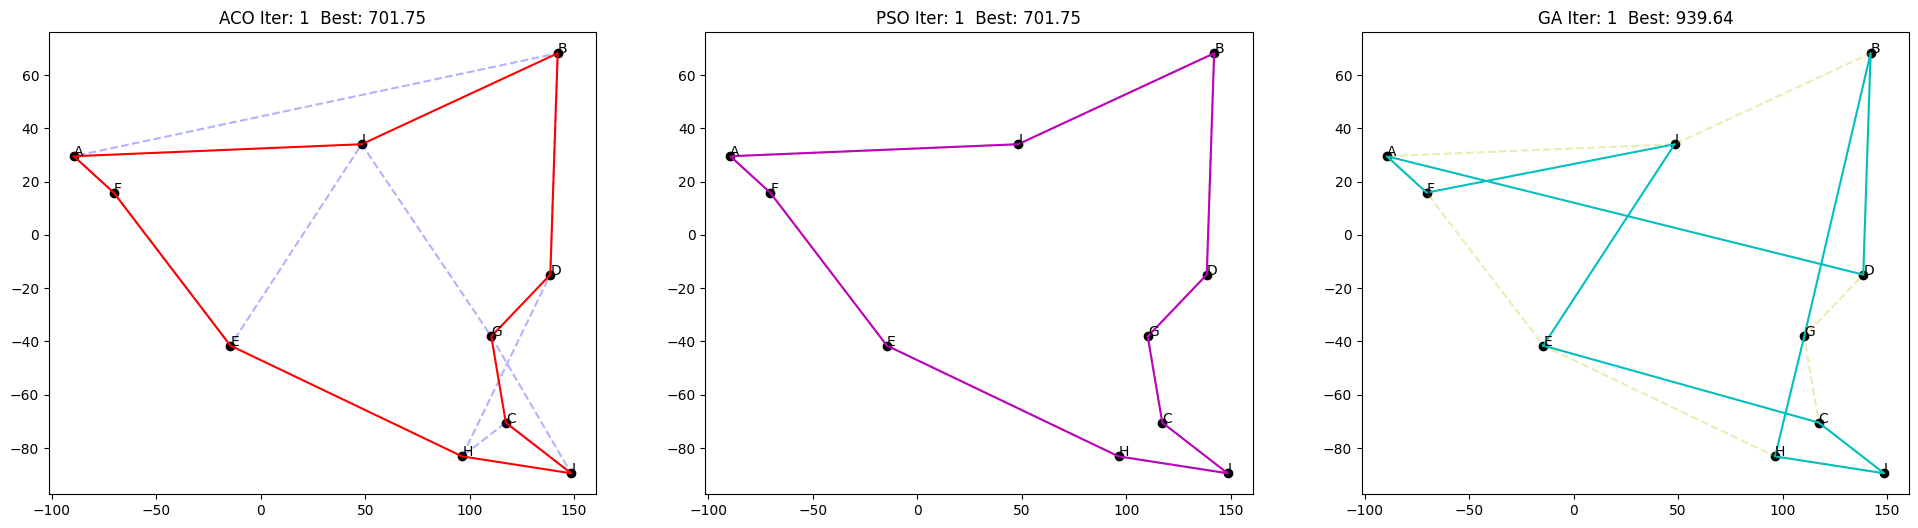

In [8]:
aco = ACO_TSP(DIS, 
              num_ants=300, 
              max_iter=100, 
              alpha=1, 
              beta=3, 
              rho=0.1, 
              Q=1)
pso = PSO_TSP(DIS,
              num_particles=200, 
              max_iter=100, 
              greedy_solutions=0)
ga = GA_TSP(DIS, 
            pop_size=200, 
            max_iter=100, 
            pc=0.5, 
            pm=0.2, 
            greedy_ratio=0)

# sed = np.random.randint(0, 10000)
np.random.seed(313)  # 312
# print(f'running seed: {sed}')

aco.run()
pso.run()
ga.run()

max_frames = max(len(aco.frames), len(pso.frames), len(ga.frames))
all_frames = []
for i in range(max_frames):
    aco_frame = aco.frames[i] if i < len(aco.frames) else aco.frames[-1]
    pso_frame = pso.frames[i] if i < len(pso.frames) else pso.frames[-1]
    ga_frame = ga.frames[i] if i < len(ga.frames) else ga.frames[-1]
    all_frames.append( (aco_frame, pso_frame, ga_frame) )


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

def update(frame):
    aco_frame, pso_frame, ga_frame = all_frames[frame]

    # ACO
    ax1.clear()
    ax1.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax1.annotate(txt, (x[i], y[i]))
    ax1.plot(aco_frame[1], aco_frame[2], 'b--', alpha=0.3)
    ax1.plot(aco_frame[3], aco_frame[4], 'r-')
    ax1.set_title(f"{aco_frame[0]} Iter: {frame+1}  Best: {aco_frame[5]:.2f}")

    # PSO
    ax2.clear()
    ax2.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax2.annotate(txt, (x[i], y[i]))
    ax2.plot(pso_frame[1], pso_frame[2], 'g--', alpha=0.3)
    ax2.plot(pso_frame[3], pso_frame[4], 'm-')
    ax2.set_title(f"{pso_frame[0]} Iter: {frame+1}  Best: {pso_frame[5]:.2f}")

    # GA
    ax3.clear()
    ax3.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax3.annotate(txt, (x[i], y[i]))
    ax3.plot(ga_frame[1], ga_frame[2], 'y--', alpha=0.3)
    ax3.plot(ga_frame[3], ga_frame[4], 'c-')
    ax3.set_title(f"{ga_frame[0]} Iter: {frame+1}  Best: {ga_frame[5]:.2f}")
    
    return ax1, ax2, ax3

ani = FuncAnimation(fig, update, frames=len(all_frames), interval=300)

# show in kernel
# HTML(ani.to_html5_video())

ani.save(f'./assets/tsp_{NUM_CITYS}.gif', writer='pillow', fps=5)